In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [32]:
df = pd.read_csv(r"/content/fdc_small_78634_20cols.csv", low_memory=False)
print("Initial shape:", df.shape)
df.head()


Initial shape: (78634, 20)


,fdc_id,brand_owner,description,ingredients,gtin_upc,serving_size,serving_size_unit,branded_food_category,modified_date,available_date,"Calcium, Ca-MG","Carbohydrate, by difference-G",Cholesterol-MG,"Copper, Cu-MG",Energy-KCAL,"Fatty acids, total monounsaturated-G","Fatty acids, total polyunsaturated-G","Fatty acids, total saturated-G","Fatty acids, total trans-G","Fiber, soluble-G"
0,1512818,"C & C Cola Co., Inc.",COLA,"CARBONATED WATER, HIGH FRUCTOSE CORN SYRUP, CA...",41699128118,355.0,ml,Soda,2018-08-10,2021-03-19,NaN,10.99,NaN,NaN,45.0,NaN,NaN,NaN,NaN,NaN
1,1612821,Hannaford Bros. Co.,HOMESTYLE CHICKEN & RICE SOUP,"CHICKEN BROTH, CARROTS, ROASTED WHITE MEAT CHI...",41268143597,245.0,g,Canned Soup,2019-09-10,2021-03-19,8.0,6.53,4.0,NaN,41.0,0.0,0.0,0.00,0.00,NaN
2,2597262,Aron Streit Inc.,"EGG & ONION MATZOS, EGG; ONION","UNBLEACHED WHEAT FLOUR, WATER, ONION POWDER, E...",70227500058,28.0,GRM,Crackers & Biscotti,2023-06-23,2023-07-13,50.0,82.14,54.0,NaN,393.0,NaN,NaN,0.00,0.00,NaN
3,1634603,Sabra Dipping Company LLC,BABAGANOUSH,"EGGPLANT, MAYONNAISE (COTTONSEED OIL, EGG YOLK...",40822343206,28.0,g,Dips & Salsa,2020-12-01,2021-03-19,0.0,7.14,18.0,NaN,250.0,NaN,NaN,3.57,0.00,NaN
4,574083,Food Town Stores Inc.,CORNED BEEF HASH,"BEEF, REHYDRATED POTATOES, WATER, CONTAINS 2% ...",035826105820,236.0,g,Chili & Stew,2018-04-10,2019-04-01,11.0,9.32,34.0,NaN,161.0,NaN,NaN,4.66,0.64,NaN


In [21]:
drop_cols = ['fdc_id','brand_owner','description','ingredients','gtin_upc','modified_date','available_date']
df.drop(columns=drop_cols, inplace=True)
df.drop_duplicates(inplace=True)
df.dropna(thresh=len(df.columns)//2, inplace=True) # --> Thresh ==> No of non-null values req to keep the row!


In [22]:
print(df.head(10))
print(df.shape)

    serving_size serving_size_unit  branded_food_category  Calcium, Ca-MG  \
1          245.0                 g            Canned Soup             8.0   
2           28.0               GRM    Crackers & Biscotti            50.0   
3           28.0                 g           Dips & Salsa             0.0   
4          236.0                 g           Chili & Stew            11.0   
5           30.0                 g           Other Snacks            10.0   
7           55.0                 g  Pasta by Shape & Type            36.0   
8           35.0                 g           Other Snacks             NaN   
9           61.0                 g   Other Cooking Sauces             0.0   
10         354.0                ml           Other Drinks             NaN   
11         237.0                ml       Plant Based Milk             8.0   

    Carbohydrate, by difference-G  Cholesterol-MG  Copper, Cu-MG  Energy-KCAL  \
1                            6.53             4.0            NaN       

In [23]:
num_cols = df.select_dtypes(include=['float64','int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

df[num_cols] = df[num_cols].fillna(df[num_cols].median())
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

for c in cat_cols:
    df[c] = LabelEncoder().fit_transform(df[c])


In [24]:
for col in num_cols:
    l, u = df[col].quantile([0.01, 0.99]) # ==> Winsorization --> removes 2% of outliers
    df[col] = np.clip(df[col], l, u)


In [25]:
X = df.drop(columns=['Energy-KCAL'])
y = df['Energy-KCAL']


In [26]:
selector = SelectKBest(f_regression, k=12)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Selected Features:", list(selected_features))


Selected Features: ['serving_size', 'serving_size_unit', 'branded_food_category', 'Calcium, Ca-MG', 'Carbohydrate, by difference-G', 'Cholesterol-MG', 'Copper, Cu-MG', 'Fatty acids, total monounsaturated-G', 'Fatty acids, total polyunsaturated-G', 'Fatty acids, total saturated-G', 'Fatty acids, total trans-G', 'Fiber, soluble-G']


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)


In [28]:
tree = DecisionTreeRegressor(max_depth=12, min_samples_split=10, random_state=42)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)


In [29]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("Decision Tree Results:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")


Decision Tree Results:
MAE: 37.2638
RMSE: 65.0118
R2: 0.8706


In [30]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cross_r2 = cross_val_score(tree, X_selected, y, cv=kf, scoring='r2').mean()
print(f"5-Fold CV R2: {cross_r2:.4f}")


5-Fold CV R2: 0.8702


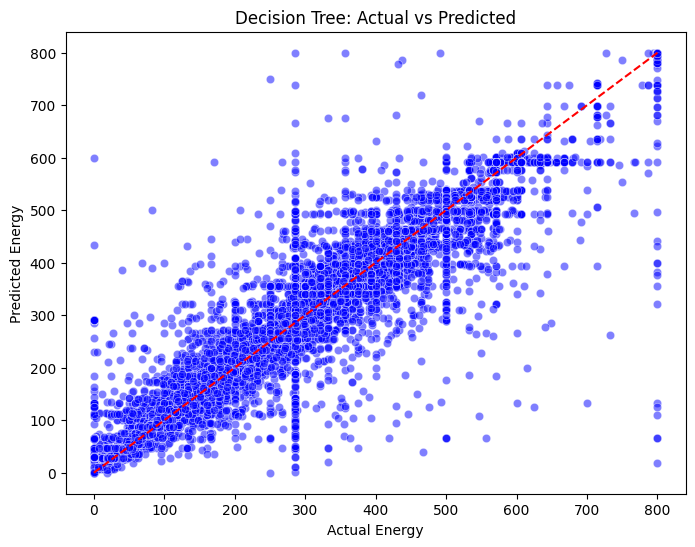

In [31]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Energy')
plt.ylabel('Predicted Energy')
plt.title('Decision Tree: Actual vs Predicted')
plt.show()
